In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

# webscraping
import json
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os

# plotting/mapmaknig/
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow
# import folium

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
gis_folder = f'{home_path}\\GIS'

In [3]:
files = glob.glob(f"{data_folder}\\*.txt")
files

['C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\120_days_01310521.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\2007-2010_01310521.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\station_ids.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\station_ids_with_Q.txt']

### station information:
station generated by considering all station in the same hydraulic unit, ids from search on USGS site

In [4]:
ids = np.loadtxt(f'{data_folder}\\station_ids.txt').astype(np.int64)

In [5]:
len(ids)

109

In [6]:
begin_end_date_csv = f"{data_folder}\\Q_ids_with_begin-end-date.csv"
if os.path.exists(begin_end_date_csv):
    df_id_dates = pd.read_csv(begin_end_date_csv,index_col=0)
    df_id_dates.set_index("ID",inplace=True)
# if False:
#     pass
else:
    lst_begin_date  = []
    lst_end_date    = []
    lst_no_flow     = []
    lst_description = []
    for i in ids:
    # for i in [1375000]: 
        print(i,end="\r")
        url_start_table = "https://waterdata.usgs.gov/nwis/inventory/?site_no="
        end = "&agency_cd=USGS"
        site = url_start_table + f'0{i}' + end
        page = urlopen(site)
        html_bytes = page.read()
        html = html_bytes.decode("utf-8")
        table = html[html.find('<div id="stationTable">'):html.find("</table>")]
        table_data = [[cell.text.strip() for cell in row("td")]
                                 for row in BeautifulSoup(table)("tr")][2:]
        headers = [[cell.text.strip() for cell in row("th")]
                              for row in BeautifulSoup(table)("tr")][0]
        df_station = pd.DataFrame(data=table_data, columns=headers)
        try:
            series_begin_date = df_station.set_index("Data Type").loc["Discharge, cubic feet per second","Begin Date"]
            series_end_date   = df_station.set_index("Data Type").loc["Discharge, cubic feet per second","End Date"]
            description       = '; '.join([cell.text.strip().replace(u'\xa0', u'') for cell in BeautifulSoup(table)("dd")][:3])
            if type(series_begin_date) == str:
                begin_date = series_begin_date
                end_date   = series_end_date
            else:
                begin_date = series_begin_date.iloc[0]
                end_date = series_end_date.iloc[0]

            lst_begin_date.append(begin_date)
            lst_end_date.append(end_date)
            lst_description.append(description)
        except KeyError:
            lst_no_flow.append(i)
    
    df_id_dates = pd.DataFrame(data=list(zip(ids,lst_begin_date,lst_end_date,lst_description)), columns=["ID","Begin Date","End Date","Description"])
    df_id_dates["Area_temp"] = df_id_dates.apply(lambda x: x.Description[x.Description.find("Drainage area")+15:x.Description.find("square miles")-1], axis=1)
    df_id_dates["Area_m2"]   = df_id_dates.apply(lambda x: float(x.Area_temp.replace(u",","")) * 2.59e+6    
                                                    if (x.Area_temp[0].isnumeric() and len(x.Area_temp) < 6)
                                                    else -999, axis=1)
    df_id_dates.drop(columns=["Area_temp"], inplace=True)
    df_id_dates.to_csv(begin_end_date_csv)
    df_id_dates.set_index("ID",inplace=True)


In [7]:
len(df_id_dates)

109

In [8]:
df_id_dates

,Begin Date,End Date,Description,Area_m2
ID,,,,
131199050,2007-01-25,2010-05-09,"Latitude 43°58'38.6"", Longitude 74°16'13.5""...",6.526800e+07
1311992,1990-12-01,1992-04-30,"Latitude 43°58'56"", Longitude 74°14'08"" NA...",3.496500e+06
1312000,1925-10-01,2023-04-03,"Latitude 43°57'57.7"", Longitude 74°07'53.0""...",4.972800e+08
1313500,1930-10-01,1961-09-29,"Latitude 43°51'23.7"", Longitude 74°14'20.6""...",4.144000e+08
1314000,1916-10-01,1968-09-29,"Latitude 43°50'02.0"", Longitude 74°11'40.8""...",1.085210e+09
...,...,...,...,...
1356190,1993-08-26,2012-09-29,"Latitude 42°47'01"", Longitude 73°51'24"" NA...",4.195800e+07
1357499,1925-10-01,2022-12-22,"Latitude 42°48'10"", Longitude 73°42'11"" NA...",-9.990000e+02
1357500,1917-12-01,2023-04-03,"Latitude 42°47'07.4"", Longitude 73°42'28.0""...",8.935500e+09


In [9]:
df_id_dates[df_id_dates.Area_m2==-999]
df_id_dates[df_id_dates.Area_m2==-999]["Description"].iloc[0]

'Latitude  43°56\'54.6",  Longitude  73°59\'18.1"  NAD83; Essex County, New York,  Hydrologic Unit 02020001; Drainage area: .09 square miles'

In [10]:
len(df_id_dates[df_id_dates.Area_m2>-999])

102

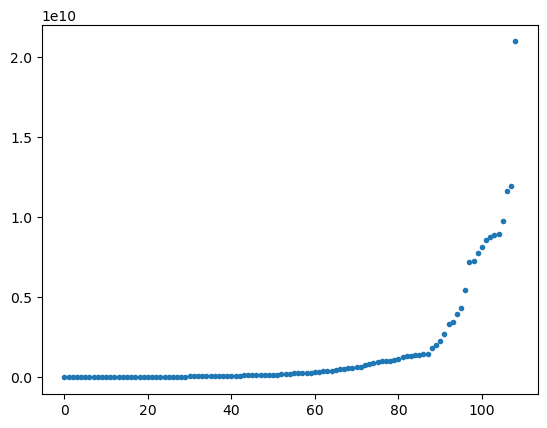

In [11]:
plt.plot(sorted(df_id_dates["Area_m2"].values),marker=".",lw=0)

In [12]:
df_id_dates.Area_m2.argmax()

107

In [13]:
df_id_dates.iloc[[17]].Description.iloc[0]

'Latitude  43°22\'11",  Longitude  74°19\'26"  NAD83; Hamilton County, New York,  Hydrologic Unit 02020002; Drainage area: 210 square miles'

In [14]:
8000*2589988.11 

20719904880.0

In [15]:
len("Drainage area")

13

#### Hourly: 

too specific

In [16]:
url_start = "https://waterservices.usgs.gov/nwis/iv/?sites="
pram = "&parameterCd=00060"
start = "&startDT="
t0 = "2023-03-15T05:45:18.716-04:00"
end_time = "&endDT="
tend = "2023-03-22T05:45:18.716-04:00"
post_fix = "&siteStatus=all&format=rdb"

# Daily

Webscrape the USGS data

In [17]:
url_start_daily = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no="
begin_date = "&legacy=&referred_module=sw&period=&begin_date="
end_data = "&end_date="

In [18]:
lst_data   = []
lst_errors = []
found_ids  = []

if len(glob.glob(f"{data_folder}\\Q\\*.parquet")) > 20:
    for path in glob.glob(f"{data_folder}\\Q\\*.parquet"):
        df = pd.read_parquet(path)
        # check columns integrity, else this will fail
        df = df[['agency_cd', 'site_no', 'Data codes', 'Q_m3_s_mean']]
        df = df[df["Q_m3_s_mean"]>-999]
        site_no = df['site_no'].iloc[0]
        found_ids.append(site_no)
        area = df_id_dates.loc[site_no,"Area_m2"]
        df["Area_USGS"] = area
        df["Q_mm_d"]  = df["Q_m3_s_mean"]  * 86400 / area * 1000  # s -> d, m3 -> mm
        lst_data.append(df)
# if False:
#     pass
else:
    for number, i in enumerate(df_id_dates.index):
        print(f'{number}/{len(df_id_dates)}',end="\r")
        condition = True
        if condition: # mainly for debugging 
            site = url_start_daily + f'0{i}' + begin_date + df_id_dates.loc[i,"Begin Date"] \
                                                                   + end_data + df_id_dates.loc[i,"End Date"]
            
            page = urlopen(site)
            html_bytes = page.read()
            html = html_bytes.decode("utf-8")
            if html[:19] == "No sites/data found":
                lst_errors.append(i)
                pass
            elif len(html) < 1700:
                lst_errors.append(i)
                pass
            else:
                data = html[html.find("\n# \n")+4:].split('\n')
                header = data[0].split("\t")
                if header[0] == "agency_cd":
                    header = ['agency_cd', 'site_no', 'datetime', 'Q_ft3_s_mean',
                       'Data codes']
                else: 
                    print(i, header)
                rows = data[2:]
                df = pd.DataFrame(data=[row.split('\t')[:5] for row in rows],columns=header)
                df.replace({"":pd.NA},inplace=True)
                df.dropna(inplace=True)
                df["Q_m3_s_mean"] = df.apply(lambda x: float(x['Q_ft3_s_mean']) * 0.0283168466\
                                             if x['Q_ft3_s_mean'][0].isnumeric()
                                             else -999, axis=1)
                df_out = df[['agency_cd', 'site_no', 'datetime', 'Data codes', 'Q_m3_s_mean']]
                df.set_index("datetime",inplace=True, drop=True,append=False)
                lst_data.append(df_out)
    # post processing
    if len(lst_errors) > 0:
        arr_errors = np.array(lst_errors)
        found_ids = list(set(df_id_dates.ID.values).difference(set(arr_errors[:,1])))
    else:
        found_ids = df_id_dates.index
    
    for df in lst_data:
        df.to_parquet(f'{data_folder}\\Q\\{df.iloc[0]["site_no"]}.parquet')
    
    # save to access later
    np.savetxt(f"{data_folder}\\station_ids_with_Q.txt",np.array(found_ids))

The 218 stations with data in the given time are store in lst_data

In [19]:
lst_data[0]

,agency_cd,site_no,Data codes,Q_m3_s_mean,Area_USGS,Q_mm_d
datetime,,,,,,
2007-01-25,USGS,131199050,A,1.019406,65268000.0,1.349463
2007-01-26,USGS,131199050,A,0.903307,65268000.0,1.195774
2007-01-27,USGS,131199050,A,0.858000,65268000.0,1.135798
2007-01-28,USGS,131199050,A,0.858000,65268000.0,1.135798
2007-01-29,USGS,131199050,A,0.835347,65268000.0,1.105810
...,...,...,...,...,...,...
2010-05-05,USGS,131199050,A,1.220456,65268000.0,1.615607
2010-05-06,USGS,131199050,A,1.277090,65268000.0,1.690577
2010-05-07,USGS,131199050,A,1.231783,65268000.0,1.630601


#### investigate a given station:

In [34]:
wanted_index = list(ids).index(1354083)
# wanted_index = 107
wanted_index

101

##### loading geopackages to make map

In [35]:
gdf_station       = gpd.read_file(f"{gis_folder}\\discharge_stations.gpk",driver="GPKG",crs="EPSG:4326")   
# fixing indexing
gdf_station.index = gdf_station.apply(lambda x: int(x.site_no[1:]),axis=1)
gdf_station       = gdf_station.drop(columns=["site_no"])

outline           = gpd.read_file(f"{gis_folder}\\hudson_basin.SHP",driver="SHP",crs="EPSG:26918")
main_rivers       = gpd.read_file(f"{gis_folder}\\main_rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   
all_rivers        = gpd.read_file(f"{gis_folder}\\rivers_hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")   

# fixing crs
for layer in [outline,main_rivers,all_rivers]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

In [36]:
def plot_map(ax, station_id):
    legend_field = []

    # stations
    gdf_station.plot(ax=ax, markersize=2, color="C1")
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='station'))

    outline.plot(ax=ax, edgecolor="C3", facecolor="None")
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)

    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

    # add background
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    
    # remove lat/lon markers
    ax.set_xticks([])
    ax.set_yticks([])
    
    # zoom on one station
    given_station = gdf_station.loc[[station_id]]
    given_station.plot(ax=ax, color="C0",markersize=20)
    x, y = given_station.geometry.x.iloc[0], given_station.geometry.y.iloc[0]
    n = 1
    ax.set_xlim(x- n,x + n)
    ax.set_ylim(y -(2*n/3),y + (2*n/3))


#### retrieve the station

Extra area check using the area from hydrosheds which contains upstream area from DEM

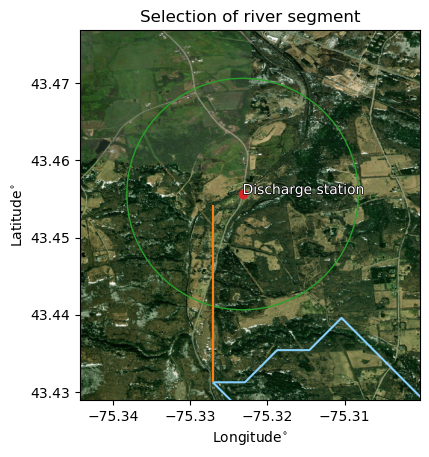

In [37]:
dict_area = {}
for i in range(len(gdf_station)):
    point_discharge = gdf_station.iloc[i].geometry.buffer(0.015)
    selected_segement =  all_rivers[all_rivers.crosses(point_discharge)]
    dict_area[gdf_station.iloc[i].name] = selected_segement["UPLAND_SKM"].max() * (10**6)
    
#### plotting ####

buffers = gpd.GeoDataFrame(index=[0],geometry=[point_discharge],crs="epsg:4326")
fig, ax = plt.subplots(1)

try:
    selected_segement.iloc[[0]].plot(ax=ax)
    selected_segement.iloc[[-1]].plot(ax=ax,color="C1")
    gdf_station.iloc[[i]].plot(ax=ax,color="C3")
    
    buffers.plot(ax=ax,facecolor="none",edgecolor="C2")
    ax.annotate("Discharge station",(gdf_station.iloc[[i]].geometry.x, 
                                     gdf_station.iloc[[i]].geometry.y),
               zorder=10, color="w",
               path_effects=[mpl.patheffects.withStroke(linewidth=1, foreground="k")])
    
    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
    all_rivers.plot(ax=ax,color="lightskyblue",zorder=1)
    with rasterio.open(get_background_map(f"river_selction_{i}", bounds_stations)) as r:
        rioshow(r, ax=ax)
    
        
    ax.set_xlabel("Longitude$^{\circ}$");
    ax.set_ylabel("Latitude$^{\circ}$");
    ax.set_title("Selection of river segment")
except IndexError:
    print("no segement found")

link this data to dfs

In [38]:
lst_data[0].head()

,agency_cd,site_no,Data codes,Q_m3_s_mean,Area_USGS,Q_mm_d,Q_mm_d_hydro
datetime,,,,,,,
2007-01-25,USGS,131199050,A,1.019406,65268000.0,1.349463,1.142370
2007-01-26,USGS,131199050,A,0.903307,65268000.0,1.195774,1.012267
2007-01-27,USGS,131199050,A,0.858000,65268000.0,1.135798,0.961495
2007-01-28,USGS,131199050,A,0.858000,65268000.0,1.135798,0.961495
2007-01-29,USGS,131199050,A,0.835347,65268000.0,1.105810,0.936109


In [39]:
for df in lst_data:
    site_no = df.iloc[0].site_no
    area_hydrosheds = dict_area[site_no]
    area_usgs = df.iloc[0].Area_USGS
    df["Q_mm_d_hydro"] = df["Q_m3_s_mean"] * 3600 * 24 / area_hydrosheds * 1000

In [40]:
lst_data[0].head()

,agency_cd,site_no,Data codes,Q_m3_s_mean,Area_USGS,Q_mm_d,Q_mm_d_hydro
datetime,,,,,,,
2007-01-25,USGS,131199050,A,1.019406,65268000.0,1.349463,1.142370
2007-01-26,USGS,131199050,A,0.903307,65268000.0,1.195774,1.012267
2007-01-27,USGS,131199050,A,0.858000,65268000.0,1.135798,0.961495
2007-01-28,USGS,131199050,A,0.858000,65268000.0,1.135798,0.961495
2007-01-29,USGS,131199050,A,0.835347,65268000.0,1.105810,0.936109


save these new files:glob.glob(f"{data_folder}\\Q\\*.csv")

In [41]:
for df in lst_data:
    ids_df = df.iloc[0].site_no
    path = f"{data_folder}\\Q\\{ids_df}.parquet"
    df.to_parquet(path)

plot

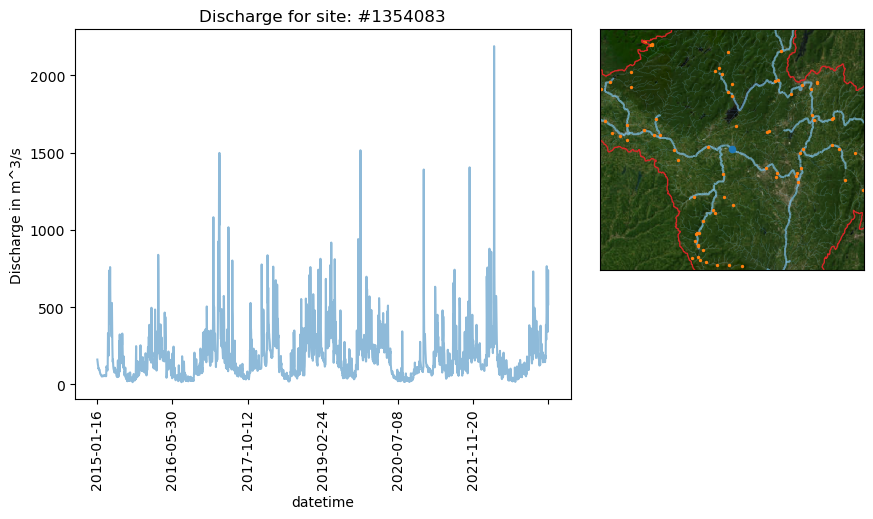

In [42]:
i = lst_data[wanted_index]
fig, ax = plt.subplots(1)
ax2 = ax.inset_axes([1.0,0.35, 0.65,0.65])
plot_map(ax2, int(i["site_no"].iloc[0]))
i[['Q_m3_s_mean']].plot(ax=ax, alpha=0.5) #lw=0, marker=".",markersize=0.5
ax.set_title(f'Discharge for site: #{i["site_no"].iloc[0]}')
ax.legend().remove()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel("Discharge in m^3/s");

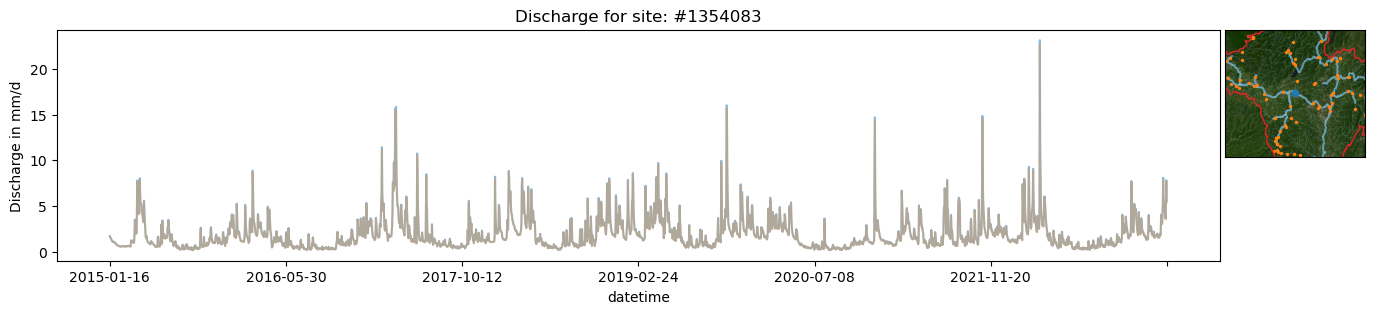

In [43]:
df = lst_data[wanted_index]
fig, ax = plt.subplots(1,figsize=(15,3))
ax2 = ax.inset_axes([.79,.45, 0.55,0.55])
plot_map(ax2, int(df["site_no"].iloc[0]))
df[['Q_mm_d']].plot(ax=ax, alpha=0.5)#,lw=0, marker=".",markersize=0.5)
df[['Q_mm_d_hydro']].plot(ax=ax, alpha=0.3)#, lw=0, marker=".",markersize=0.5)
ax.set_title(f'Discharge for site: #{df["site_no"].iloc[0]}')
ax.legend().remove()
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_ylabel("Discharge in mm/d");

In [30]:
df

,agency_cd,site_no,Data codes,Q_m3_s_mean,Area_USGS,Q_mm_d,Q_mm_d_hydro
datetime,,,,,,,
1946-02-21,USGS,1358000,A,278.071434,2.095310e+10,1.146626,1.138838
1946-02-22,USGS,1358000,A,286.000151,2.095310e+10,1.179320,1.171309
1946-02-23,USGS,1358000,A,274.107075,2.095310e+10,1.130279,1.122602
1946-02-24,USGS,1358000,A,269.010043,2.095310e+10,1.109262,1.101727
1946-02-25,USGS,1358000,A,209.827833,2.095310e+10,0.865224,0.859347
...,...,...,...,...,...,...,...
2023-03-30,USGS,1358000,P,761.723174,2.095310e+10,3.140962,3.119626
2023-03-31,USGS,1358000,P,659.782526,2.095310e+10,2.720610,2.702130
2023-04-01,USGS,1358000,P,815.525182,2.095310e+10,3.362814,3.339972


#### investigate the mean:

In [31]:
lst_mean = []
for df in lst_data:
    lst_mean.append(df['Q_mm_d'].mean())

Couple of stations that have mean bellow 0: erros in the dat? 

In [32]:
lst_mean = np.array(lst_mean)
lst_mean[lst_mean<0]

array([-4.44161431e+02, -3.55606729e+05, -2.04136186e+05, -8.33734706e+05,
       -1.21621962e+05, -1.90040380e+05, -3.75227641e+04])

(0.0, 10.0)

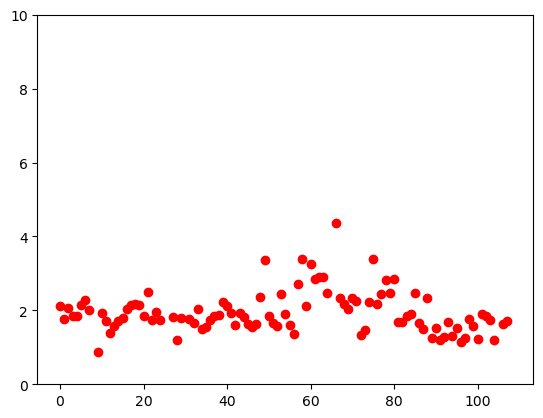

In [33]:
plt.plot(lst_mean,"ro")
plt.ylim(0,10)